In [1]:
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import log_loss, accuracy_score

from keras.utils.data_utils import Sequence
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Convolution2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input, decode_predictions

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

DATA_DIR = "../data/"
NUM_CLASSES = 228
IMAGE_SIZE = 100

C:\Users\matt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
%%time
with open(DATA_DIR + "train.json") as train, open(DATA_DIR + "test.json") as test, open(DATA_DIR + "validation.json") as validation:
    train_json = json.load(train)
    test_json = json.load(test)
    validation_json = json.load(validation)
    
def generate_paths_and_labels(json_obj, folder):
    paths, labels = [], []
    for data in json_obj['annotations']:
        label = [int(x) for x in data["labelId"]]
        image_path = DATA_DIR + "{}/id_{}_labels_{}.jpg".format(folder, data["imageId"], label)
        paths.append(image_path)
        temp_array = [0] * NUM_CLASSES
        for elem in data['labelId']:
            temp_array[int(elem) - 1] = 1
        labels.append(temp_array)
    return np.array(paths), np.array(labels)

train_paths, train_labels = generate_paths_and_labels(train_json, "train")
validation_paths, validation_labels = generate_paths_and_labels(validation_json, "validation")

Wall time: 21.8 s


C:\Users\matt\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


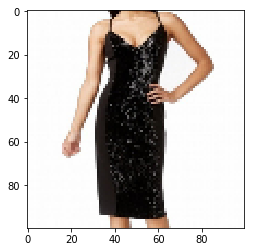

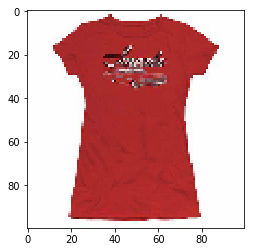

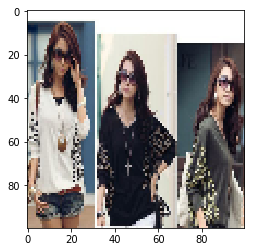

In [4]:
import random

TARGET_SIZE=(IMAGE_SIZE,IMAGE_SIZE)

def path_to_image( path):
        image = Image.open(path)
        image = np.array(image)
        image = resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        return image
    
rands = random.sample(range(1, len(train_paths)), 3)
paths = [train_paths[i] for i in rands]
images = [path_to_image(i) for i in paths]

for image in images:
    plt.imshow(image)
    plt.show()

In [6]:
class BatchSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = [self.path_to_image(file_path) for file_path in batch_x]
        return np.array(images), np.array(batch_y)
    
    def path_to_image(self, path):
        image = Image.open(path)
        image = np.array(image)
        image = resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        return image

In [7]:
### https://github.com/suraj-deshmukh/Multi-Label-Image-Classification/blob/master/miml.ipynb
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),padding='same',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 64)        18496     
__________

In [ ]:
# train_urls = train_urls[:50000]
# train_labels = train_labels[:50000]

train_paths = train_paths[:250000]
train_labels = train_labels[:250000]

EPOCHS = 5
BATCH = 64
STEPS = len(train_paths) // BATCH

train_gen = BatchSequence(train_paths, train_labels, BATCH)
val_gen = BatchSequence(validation_paths, validation_labels, BATCH)

checkpointer = ModelCheckpoint(
    filepath='model.best.hdf5', 
    verbose=1,
    save_best_only=True
)

history = model.fit_generator(
    generator = train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    steps_per_epoch = STEPS,
    callbacks = [checkpointer],
)

Epoch 1/5


C:\Users\matt\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


  25/3906 [..............................] - ETA: 1:27:01 - loss: 0.4635 - acc: 0.7846

In [ ]:
# TODO: write generator for test data
# def test_gen(X_test):
#     Y_trash = np.ones(X_test.shape[0])
#     flow = train_datagen.flow(X_test, Y_trash)
#     for X,Y in flow
#         yield X #ignore Y
# end

# model.predict_generator(test_gen(X_test),
#                         val_samples=X_test.shape[0]